In [15]:
import numpy as np
import os
import glob
import pandas as pd
import spikeinterface.extractors as se
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
import json
import re

import warnings
from astropy.stats import circmean
%matplotlib inline
from astropy.convolution import convolve, convolve_fft
from skimage.draw import disk
from pathlib import Path


In [2]:
d = 1
if d == 1:
    derivatives_base = r"D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials"
    rawsession_folder = r"D:\Spatiotemporal_task\rawdata\sub-002_id-1U\ses-01_date-02072025"
    trials_to_include = np.arange(1,9)
elif d == 2:
    derivatives_base = r"D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-02_date-03072025\all_trials"
    rawsession_folder = r"D:\Spatiotemporal_task\rawdata\sub-002_id-1U\ses-02_date-03072025"
    trials_to_include = np.arange(4,10)
else:
    derivatives_base = r"Z:\Eylon\Data\Honeycomb_Maze_Task\derivatives\sub-001_id-2B\ses-05_test\all_trials"
    rawsession_folder = r"Z:\Eylon\Data\Honeycomb_Maze_Task\rawdata\sub-001_id-2B\ses-05_test"
    trials_to_include = np.array([1,2])
frame_rate = 30
sample_rate = 30000



In [1]:
trial_length_df.trialnumber

NameError: name 'trial_length_df' is not defined

In [3]:
# Load data files
kilosort_output_path = os.path.join(derivatives_base, "ephys", "concat_run","sorting", "sorter_output" )
sorting = se.read_kilosort(
    folder_path = kilosort_output_path
)
unit_ids = sorting.unit_ids
labels = sorting.get_property('KSLabel')
good_units_ids = [el for el in unit_ids if labels[el] == 'good']

# Get the data with the epoch times
csv_path = os.path.join(rawsession_folder, 'task_metadata', 'timestamps.csv')
xlsx_path = os.path.join(rawsession_folder, 'task_metadata', 'timestamps.xlsx')
if os.path.exists(csv_path):
    epoch_times = pd.read_csv(csv_path)
elif os.path.exists(xlsx_path):
    epoch_times = pd.read_excel(xlsx_path)
else:
    raise FileNotFoundError(f"Epoch times file does not exist: {csv_path} or {xlsx_path}")


In [70]:

bin_length = 60
output_folder = os.path.join(derivatives_base, "cell_characteristics", "unit_features", "spikecount_over_trials")
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Loading data
for unit_id in tqdm(unit_ids): 
    
    output_path = os.path.join(output_folder, f"unit_{unit_id}_sc_over_trials.png")
    
    spike_train_unscaled = sorting.get_unit_spike_train(unit_id=unit_id)
    spike_train = np.round(spike_train_unscaled/sample_rate) # spike times in seconds

    total_trial_length = 0
    for tr in trials_to_include:
        trial_row = trial_length_df[(trial_length_df.trialnumber == tr)]
        trial_length = trial_row.iloc[0, 2]
        total_trial_length += trial_length

    n_bins = total_trial_length/bin_length



    # Simulated adjacent trials
    trial_lengths = np.array(trial_length_df['trial length (s)'])
    trial_ends = np.cumsum(trial_lengths)
    trial_starts = np.concatenate(([0], trial_ends[:-1]))

    # Plot
    fig =  plt.figure(figsize=(12, 5))
    plt.hist(spike_train, bins = np.int32(n_bins))

    # Vertical lines at trial boundaries
    for start in trial_starts[1:]:
        plt.axvline(x=start, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=trial_ends[-1], color='black', linestyle='--', linewidth=1)

    # Get current y-axis limits
    ymin, ymax = plt.ylim()

    # Label position: slightly below the top of the y-axis
    label_y = ymax

    # Place trial labels
    for i, (start, end) in enumerate(zip(trial_starts, trial_ends)):
        mid = (start + end) / 2
        plt.text(mid, label_y, f'Trial {i+1}',
                ha='center', va='top', fontsize=9, color='black')

    # Optional: adjust y-limit if you want more headroom
    plt.ylim(ymin, ymax * 1.05)
    plt.xlim(0, np.max(trial_ends))
    # Axis labels and title
    plt.xlabel("Time (seconds)")
    plt.ylabel("Number of spikes per minute")
    plt.title(f"Unit {unit_id}: Spike count across trials")
    plt.tight_layout()
    fig.savefig(output_path)
    plt.close()
plt.show()




In [54]:
trial_starts

array([ 448.52763333,  748.17966667, 1284.5697    , 1652.37946667,
       2165.2108    , 2562.4263    , 2866.61963333])

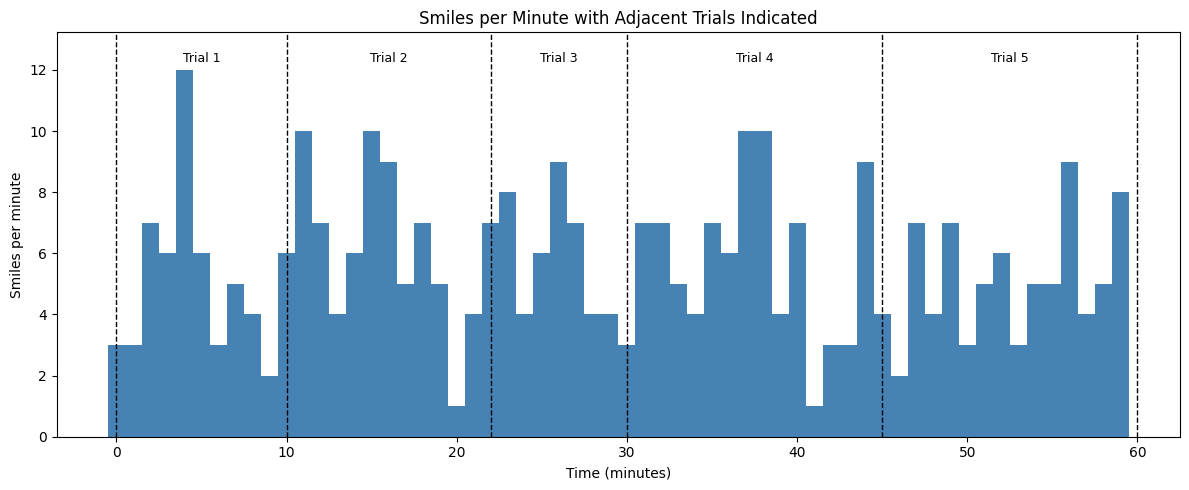

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated data: smiles per minute for 60 minutes
minutes = np.arange(60)
smiles_per_minute = np.random.poisson(5, size=60)

# Simulated adjacent trials
trial_lengths = [10, 12, 8, 15, 15]
trial_starts = np.cumsum([0] + trial_lengths[:-1])
trial_ends = np.cumsum(trial_lengths)

# Plot
plt.figure(figsize=(12, 5))
plt.bar(minutes, smiles_per_minute, width=1.0, color='steelblue', label='Smiles/min')

# Vertical lines at trial boundaries
for start in trial_starts:
    plt.axvline(x=start, color='black', linestyle='--', linewidth=1)
plt.axvline(x=trial_ends[-1], color='black', linestyle='--', linewidth=1)

# Get current y-axis limits
ymin, ymax = plt.ylim()

# Label position: slightly below the top of the y-axis
label_y = ymax

# Place trial labels
for i, (start, end) in enumerate(zip(trial_starts, trial_ends)):
    mid = (start + end) / 2
    plt.text(mid, label_y, f'Trial {i+1}',
             ha='center', va='top', fontsize=9, color='black')

# Optional: adjust y-limit if you want more headroom
plt.ylim(ymin, ymax * 1.05)

# Axis labels and title
plt.xlabel("Time (minutes)")
plt.ylabel("Smiles per minute")
plt.title("Smiles per Minute with Adjacent Trials Indicated")
plt.tight_layout()
plt.show()
